In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/llm-detect-ai-generated-text


/content/drive/MyDrive/llm-detect-ai-generated-text


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

cmap = mpl.cm.get_cmap('coolwarm')

<ipython-input-4-b4db31e05298>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [5]:
train_essays = pd.read_csv('train_essays.csv')
train_prompts = pd.read_csv('train_prompts.csv')

## Problématique : Peut on différencier les textes humains et IA ?

Avec l'évolution rapide de l'intelligence artificielle, la génération de textes par des algorithmes devient de plus en plus courante. 

Dans un monde où l'information est facilement accessible et souvent partagée, il devient crucial de pouvoir distinguer entre les textes générés par des humains et ceux produits par des systèmes d'intelligence artificielle.

Le plagiat ou la triche peut se manifester de manière subtile, car les systèmes d'IA peuvent produire des textes qui semblent originaux mais qui reposent sur des modèles préexistants et des données d'entraînement, souvent extraites de contenus protégés. Cela soulève des questions éthiques, dans le cas des élèves qui rendent un travail entièrement généré par une IA. Des professeurs qui vont plus passer à savoir si le travail a été plagié ou non que corriger le contenu en lui-même. Autres que la triche à l'école, l'IA est aussi controversé dans le domaine artistique par rapport au plagiat.

Ainsi notre recherche vise à savoir si on peut différencier de manière statistique les textes IA et les textes humains.

Pour cela on va s'appuyer sur un jeu de données disponible dans kaggle : 
https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/

## Visualisation des données

Voici les deux instructions qui ont été données aux étudiants (dans le train) afin qu'ils écrivent leurs essais :

In [6]:
train_prompts['instructions'][0]

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [7]:
train_prompts['instructions'][1]

'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'

On peut noter que les sujets ont été bien répartis parmi les élèves :

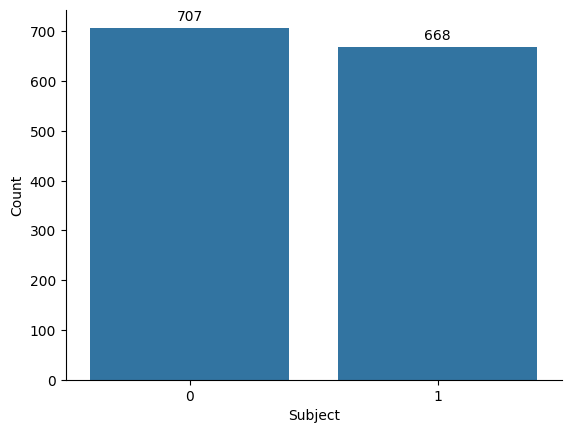

In [8]:
def count_plot(data, column, x_label) :
  ax = sns.countplot(x=column, data=data)

  plt.xlabel(x_label)
  plt.ylabel("Count")

  for side in ['top', 'right'] :
    ax.spines[side].set_visible(False)

  for p in ax.patches:
    height = p.get_height()
    ax.annotate(format(height, '.0f'),
                  xy=(p.get_x() + p.get_width() / 2, height),
                  xytext=(0, 3),
                  textcoords="offset points",
                  ha="center", va="bottom")

  plt.show()
train_essays.rename(columns={'generated': 'label'}, inplace=True)
count_plot(train_essays[train_essays['label']==0], 'prompt_id', "Subject")


Voici à présent les dimensions du train :


In [9]:
train_essays.shape

(1378, 4)

(Reprendre la section `data` de la compétition Kaggle pour mieux comprendre le jeu de données et l'expérience menée)

En complément, voici quelques lignes du train :

In [10]:
train_essays.head()
train_essays[train_essays['label'] == 1].head()

,id,prompt_id,text,label
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


Et voici un exemple d'essai fait par un élève pour le premier sujet :

In [11]:
random_row = train_essays[(train_essays['prompt_id']==0) & (train_essays['label']==0)].sample(n=1)
random_row['text'].values[0]

'There are many advantages of having limitations in car use. Some examples include less car Pollution, less stress on car users, more people starting to walk, and having a sense of community, and even less stress on car users.\n\nCar pollution is a serious issue that the world faces. Constantly people are using cars, trucks, and commercial vehicles to get from point A to B. With a whoping 7 billion and growing people in the world you can start to get a sense of how many people are polluting our air. Fortunately there are many ways that we can limit car usage in the world and many have started to work on solutions already. In the article "In German Suburb, Life Goes On Without Cars" by Elisabeth Rosenthal she explains that in Vauban, Germany Residents are taking a stand against car use. She goes on to explain that 70 percent of the Vauban families do not even own cars and more than half of the population sold their cars so that they could move them and their families to the society. One

Et pour le second sujet :

In [12]:
random_row = train_essays[(train_essays['prompt_id']==1) & (train_essays['label']==0)].sample(n=1)
random_row['text'].values[0]

"The Electoral College is a group of selected electors for deciding the president. Each state has its own amount of electors depending on its population. States like California have fifty five electors, while Wyoming would only have three. This factor makes the Electoral College flawed. The electoral college can also ignore their states votes. On the other hand, popular vote is not dependent on the population of the state. Having all the votes go directly to which candidate they was voted for. This would allow the presidential candidates go to all areas of the United States. So although many think their vote goes directly to who they voted for, the Electoral College has the final say.\n\nThe main problem with the electoral college is that every state has its own number of electors. Smaller, less populated states are ignored during the election, while the presidents focus directly on high population states to get more electoral votes. Since most states go off a winnertakesall basis, all

Néanmoins, on remarque que les données sont anormalements réparties. En effet, très peu de données ont été générées par l'IA : On a 1375 écrits par les élèves et 3 générés par l'IA

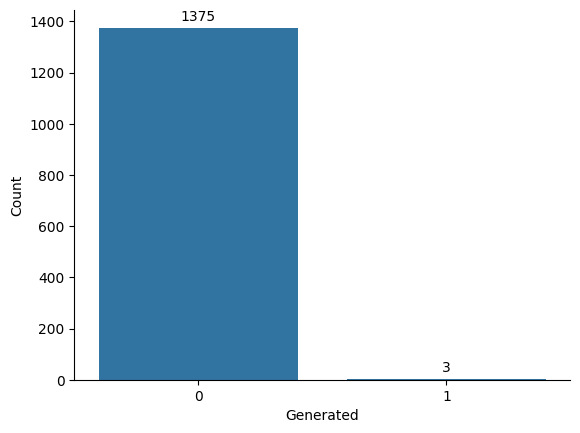

In [13]:
count_plot(train_essays, 'label', "Generated")

## Deuxième étape : concaténer avec d'autres données

Nous allons nous appuyer sur un jeu de données suivant :
- https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/

D'ailleurs, on peut remarquer que notre jeu de données de base découle probablement de ces sources (mais nous allons faire quelques traitements avant la fusion comme retirer les quasi-redondances générées par les LLMs ou réduire le nombre d'échantillons).


In [14]:
daigt = pd.concat([pd.read_csv('train_drcat_01.csv'), pd.read_csv('train_drcat_02.csv'), pd.read_csv('train_drcat_03.csv'), pd.read_csv('train_drcat_04.csv')], axis=0)
daigt.head()

,text,label,source,fold,essay_id,prompt
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2,NaN,NaN
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4,NaN,NaN
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0,NaN,NaN
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0,NaN,NaN
4,My argument for the development of the driverl...,0,persuade_corpus,3,NaN,NaN


On retire brièvement les potentiels doublons (sans exception) étant donné l'origine du jeu de données de base :

In [15]:
daigt = daigt[(daigt['prompt'] != train_prompts['instructions'][0]) & (daigt['prompt'] != train_prompts['instructions'][1])]

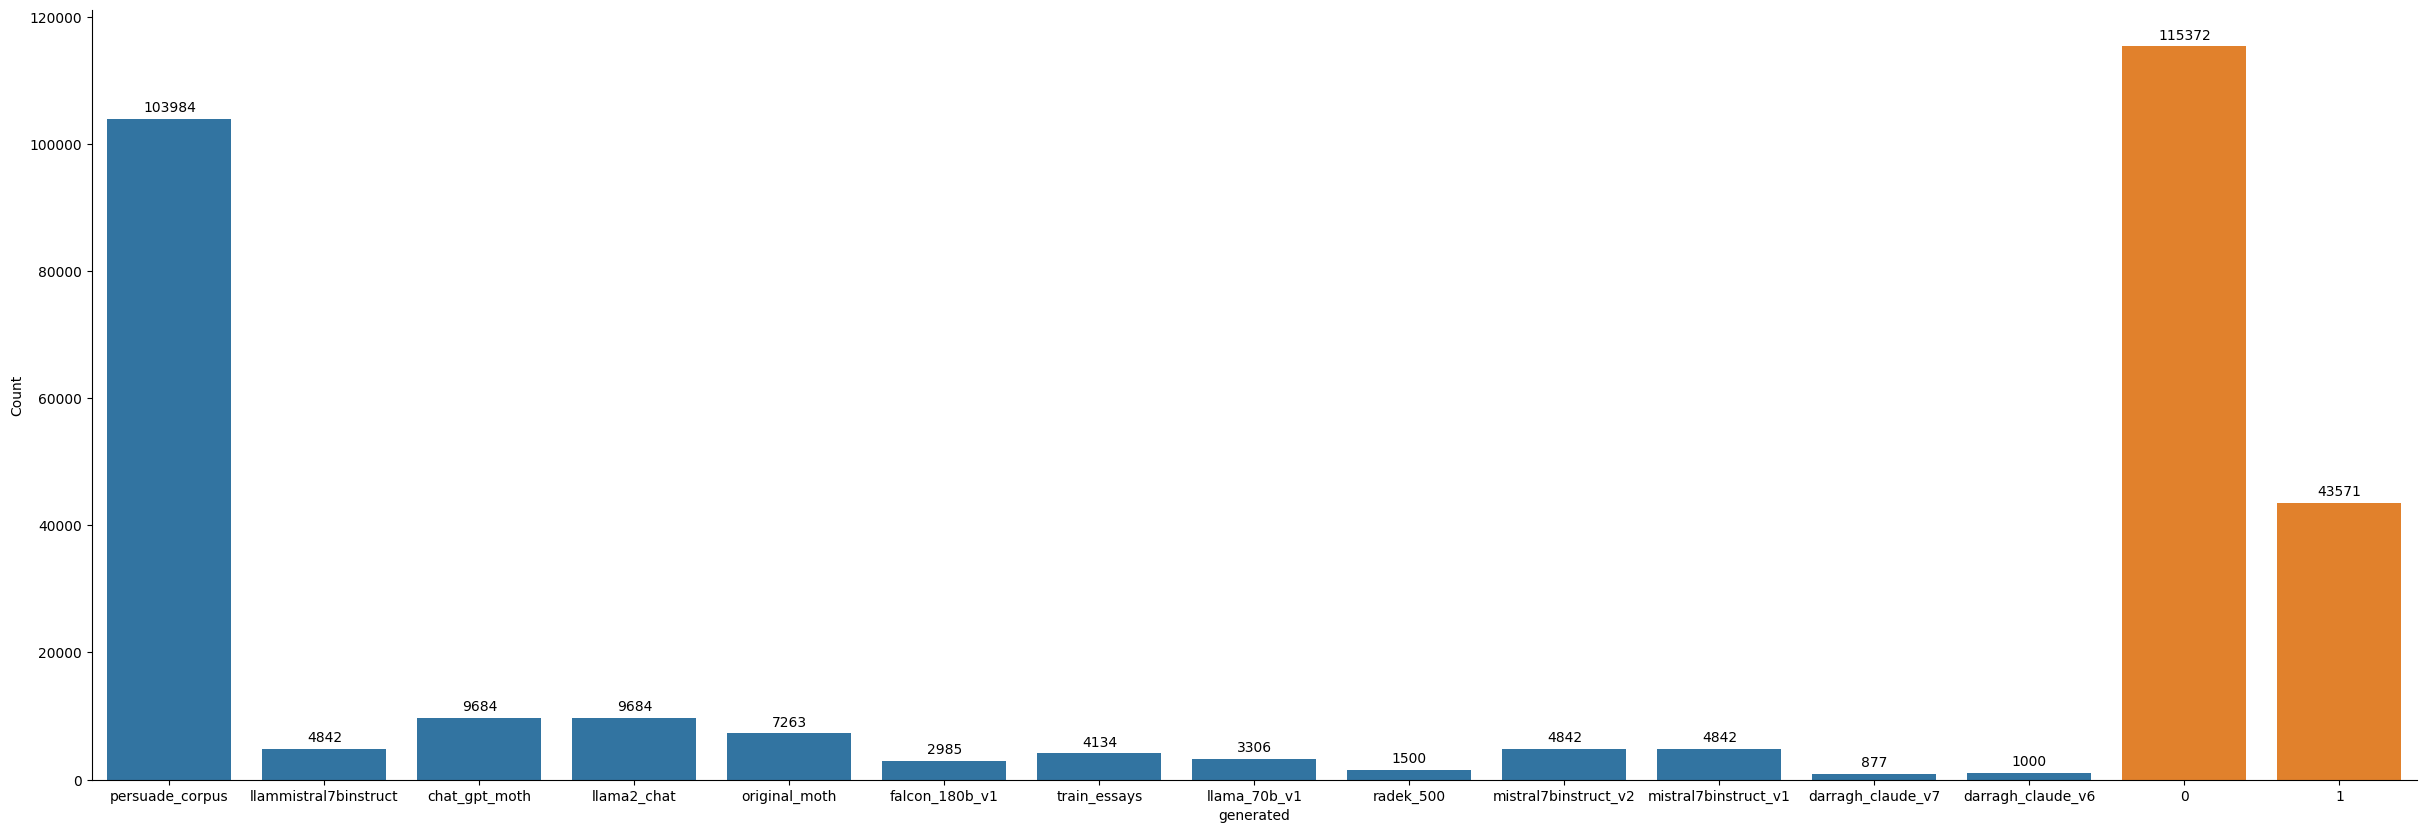

In [16]:
daigt.head()
# Create subplots with specified size
fig, ax = plt.subplots(figsize=(30, 10))

# Create the count plot
sns.countplot(daigt, x='source', ax=ax)
count_plot(daigt,"label","generated")


Le fold correspond à un groupe de personnes de même profession ou pratiquement identique par exemple un groupe de professeurs, d'enfants, d'adolescents...
On peut voir que le fold est majoritairement bien répartis

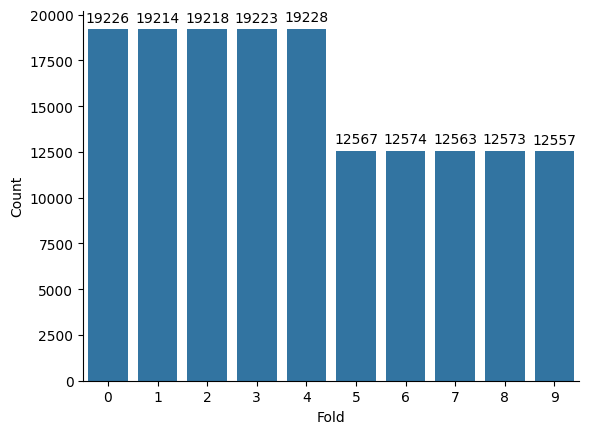

In [17]:
# Create subplots with specified size
daigt.reset_index(drop=True, inplace=True)

count_plot(daigt,"fold","Fold")

In [18]:

train = pd.concat([train_essays[['text', 'label']], daigt], axis=0)

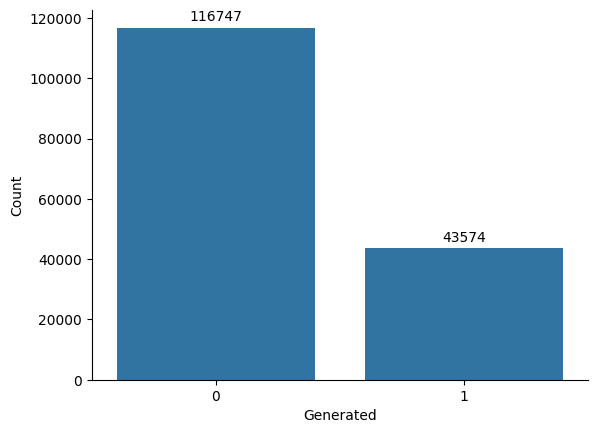

In [19]:
train.reset_index(drop=True, inplace=True)

count_plot(train, 'label', "Generated")

Apres concaténation et enlevement de doublons et nettoyage de données, on va resize le dataset en prenant 2000 textes écrits par l'humain et 2000 textes générés par l'IA parce qu'il y en a beaucoup.

Le resize doit etre random car notre étude soit non biaisé et qu'elle permette de classifier/ distinguer de manière générale les LLMs

In [20]:
train = pd.concat([
    train[train.label == 1 ].sample(2000),
    train[train.label == 0 ].sample(2000),
])

train1 = train.copy()

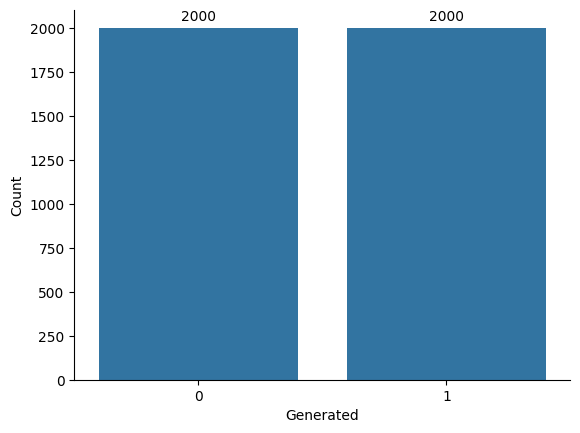

In [21]:
count_plot(train, 'label', "Generated")

## Nettoyage de données


On va d'abord enlever les points,virgules,chiffres et tout autres caracteres speciaux et tout mettre en minuscule.

In [22]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text


train['text'] = train['text'].apply(normalize_text)

On va nettoyer les données en utilisant le stemming technique pour regrouper plusieurs mots diffents, utilise si on veut utiliser TF IDF

In [24]:
import nltk
from nltk.stem import PorterStemmer
import re

# Initialiser le stemmer de NLTK
stemmer = PorterStemmer()

def stem_text(text):
    # Enlever les caractères spéciaux
    # Tokenisation du texte en mots
    tokens = word_tokenize(text)

    # Stemming de chaque mot
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Rejoindre les mots stemmés en une seule chaîne de caractères
    stemmed_text = ' '.join(stemmed_tokens)

    return stemmed_text

# Appliquer le stemming à la colonne 'text' de votre DataFrame train
train['text'] = train['text'].apply(stem_text)

In [25]:
train.head()

,text,label,source,fold,essay_id,prompt
7243,hey averag th grade student essay research dev...,1,llama2_chat,4.0,NaN,NaN
134996,navig way medic mechan workshop dazzl variou c...,1,chat_gpt_moth,2.0,F3A5981B0288,Task: Research various careers to decide what ...
35914,eighthgrad student import valu someon look exa...,1,llammistral7binstruct,2.0,82294A32E3E3,NaN
84188,distanc learn becom increasingli popular year ...,1,chat_gpt_moth,1.0,BD4BFB4E8C6B,Task:\n\nWrite an essay exploring the pros and...
150309,believ first impress difficult chang imposs tr...,1,mistral7binstruct_v2,0.0,87669696162F,\nTask: Write an essay about whether or not yo...


#Analyse de la dataset

On va tout d'abord essayer de comparer la longueur des phrases IA et humaines, pour cela on va essayer de prendre plein de phrases où pour un meme prompt au moins 5 phrases humaines et 5 phrases IA.

Mais on remarque qu'il y'a juste 1 occurrence qui respecte ces critères alors la comparaison de la longueur n'est pas pertinente voire faussée car on ne peut pas comparer un prompt qui demande de rediger un essai et l'autre un petit texte par exemple une blague.

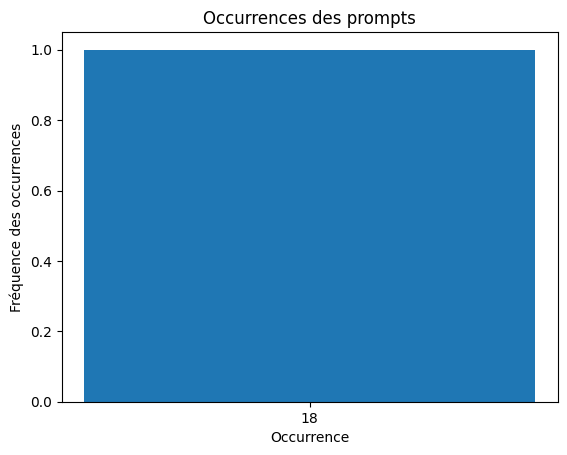

In [ ]:
import matplotlib.pyplot as plt

prompt_counts = daigt['prompt'].value_counts().sort_values(ascending=False)
occurrences = []

for prompt in prompt_counts.index :
    if prompt_counts[prompt] >= 10:
      count = prompt_counts[prompt]  # Récupérer le nombre d'occurrences pour le prompt actuel
      phrases_train_IA = daigt[(daigt['label'] == 1) & (daigt['prompt'] == prompt)]['text']
      phrases_train_humain = daigt[(daigt['label'] == 0) & (daigt['prompt'] == prompt)]['text']
      if len(phrases_train_IA)>=5 and len(phrases_train_humain) >=5:
          occurrences.append(count)

occurrence_counts = {}
for occurrence in occurrences:
    if occurrence in occurrence_counts:
        occurrence_counts[occurrence] += 1
    else:
        occurrence_counts[occurrence] = 1


unique_occurrences = list(occurrence_counts.keys())
occurrence_frequencies = list(occurrence_counts.values())

x_values = []
y_values = []

for occurrence, frequency in zip(unique_occurrences, occurrence_frequencies):
    if occurrence not in x_values:
        x_values.append(occurrence)
        y_values.append(frequency)
    else:
        y_values[x_values.index(occurrence)] += frequency

plt.bar(x_values, y_values)
plt.title("Occurrences des prompts")
plt.xlabel("Occurrence")
plt.ylabel("Fréquence des occurrences")

plt.xticks(x_values)  # Définit les valeurs de l'axe des x comme étant celles présentes dans x_values

plt.show()


Mais on peut alors comparer les phrases humaines et IA à partir des critères de lisibilité et de difficultés sans prendre en compte les critères evoqués en haut
parce que on suppose que l'IA et l'humain ont une différence stylistique et ça peu importe le prompt en général

En utilisant les indices, on va juste appliquer dans le nettoyage des données pour que la phrase soit la plus explicite possible, l'enlevement de tout ce qui est URL, chiffres,.


Avec l'indice de lisibilité Flesh score (Fleschore 0 à 100) Plus c'est haut plus c'est facile à lire. On constate alors que on constate que les phrases générées par l'IA sont beaucoup plus difficiles à comprendre.

Avec l'indice de lisibilité Grade level (Grade level de 0 à 16),  l'indice indique le niveau scolaire requis pour comprendre un texte. Il est exprimé en termes de niveau de classe aux États-Unis. Voici comment interpréter le Grade Score, On constate aussi que les textes générés par l'IA sont aussi beaucoup plus difficiles à comprendre.

Mais le plus pertinent dans cette étude statistique est l'ecart type et la variance les phrases humaines sont beaucoup plus dispersées que les phrases IA en comparant l'ecart type et la variance qui sont plus élévees pour l'homme.

On peut hypothétiser que l'IA utilise des mots plus compliqués, moins de mots communs et génèrent des phrases qui sont en général de même complexité comparé à l'homme. Cette variance est due au fold, les folds représentent un groupe de personnes de profession identique ( par exemple un fold pour les professeurs, un autre pour les employés dans les métiers très physiques...)

Il existe aussi d'autres indices comme le SMOG, l'ARI et le Gunning Fog Index

Le SMOG est un indice pour évaluer  le niveau de lecture en fonction du nombres de mots à plusieurs syllables dans un texte. Plus l'indice est haut plus le texte est complexe.


In [26]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.4 MB/s eta 0:00:00


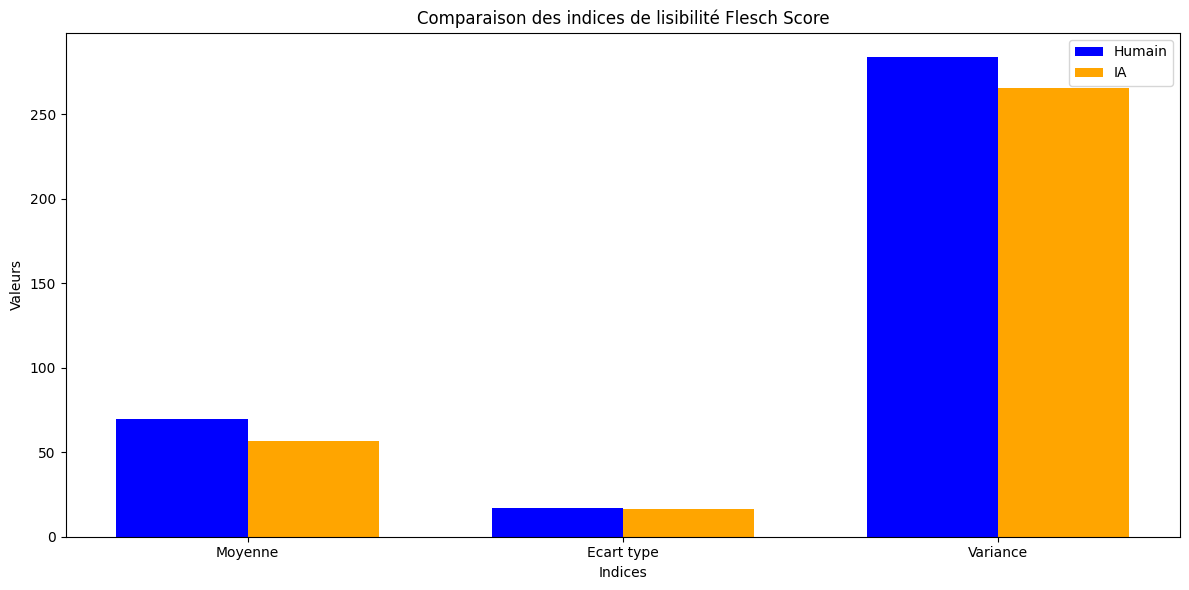

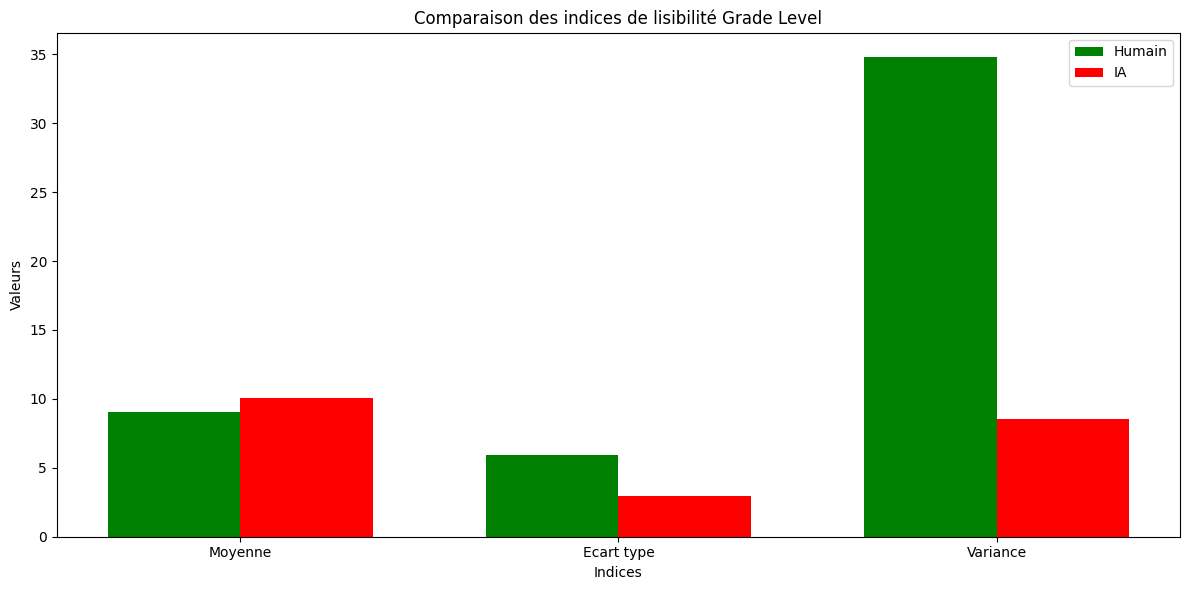

In [27]:
import textstat

def clean_text(text):
    # Enlever les URL (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Enlever les balises HTML
    text = re.sub(r'<.*?>', '', text)

    # Enlever les chiffres

    text = re.sub(r'\d+', '', text)

    return text
train1['text'] = train1['text'].apply(clean_text)

# Calculer les indices de lisibilité pour les phrases humaines
phrases_train_IA_ = train1[(train1['label'] == 1)]
phrases_train_humain_ = train1[(train1['label'] == 0)]
indices_humain = {
    'flesch_score': [textstat.flesch_reading_ease(phrase) for phrase in phrases_train_humain_['text']],
    'grade_level': [textstat.flesch_kincaid_grade(phrase) for phrase in phrases_train_humain_['text']],

}

# Calculer les indices de lisibilité pour les phrases générées par une IA
indices_IA = {
    'flesch_score': [textstat.flesch_reading_ease(phrase) for phrase in phrases_train_IA_['text']],
    'grade_level': [textstat.flesch_kincaid_grade(phrase) for phrase in phrases_train_IA_['text']],
}

# Calculer la moyenne, l'écart type et la variance des scores de lisibilité pour les phrases humaines
mean_flesch_humain = np.mean(indices_humain['flesch_score'])
std_flesch_humain = np.std(indices_humain['flesch_score'])
var_flesch_humain = np.var(indices_humain['flesch_score'])

mean_grade_humain = np.mean(indices_humain['grade_level'])
std_grade_humain = np.std(indices_humain['grade_level'])
var_grade_humain = np.var(indices_humain['grade_level'])

# Calculer la moyenne, l'écart type et la variance des scores de lisibilité pour les phrases générées par une IA
mean_flesch_IA = np.mean(indices_IA['flesch_score'])
std_flesch_IA = np.std(indices_IA['flesch_score'])
var_flesch_IA = np.var(indices_IA['flesch_score'])

mean_grade_IA = np.mean(indices_IA['grade_level'])
std_grade_IA = np.std(indices_IA['grade_level'])
var_grade_IA = np.var(indices_IA['grade_level'])

# Données
indices = ['Moyenne', 'Ecart type', 'Variance']
humain_flesch = [mean_flesch_humain, std_flesch_humain, var_flesch_humain]
IA_flesch = [mean_flesch_IA, std_flesch_IA, var_flesch_IA]
humain_grade = [mean_grade_humain, std_grade_humain, var_grade_humain]
IA_grade = [mean_grade_IA, std_grade_IA, var_grade_IA]


bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(indices)), humain_flesch, width=bar_width, label='Humain', color='blue', align='center')
plt.bar(np.arange(len(indices)) + bar_width, IA_flesch, width=bar_width, label='IA', color='orange', align='center')
plt.xticks(np.arange(len(indices)) + bar_width / 2, indices)
plt.xlabel('Indices')
plt.ylabel('Valeurs')
plt.title('Comparaison des indices de lisibilité Flesch Score')
plt.legend()
plt.tight_layout()


plt.show()

# Créer la figure et les axes pour Grade Level
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(indices)), humain_grade, width=bar_width, label='Humain', color='green', align='center')
plt.bar(np.arange(len(indices)) + bar_width, IA_grade, width=bar_width, label='IA', color='red', align='center')
plt.xticks(np.arange(len(indices)) + bar_width / 2, indices)
plt.xlabel('Indices')
plt.ylabel('Valeurs')
plt.title('Comparaison des indices de lisibilité Grade Level')
plt.legend()
plt.tight_layout()

plt.show()


# Vectorisation du texte avec TF-IDF
On ne va pas faire de pre-processing comme la supression des stopwords (les mots les plus courants comme les déterminants, les pronoms, etc.) parce qu'on pense qu'il y aura des différences notables entre le vocabulaire d'un humain et d'une IA (utilisation de mots ou expressions simplifiés contre des mots ou des expressions plus soutenus et compliqués).

Pour vectoriser notre dataset on va utiliser l'algorithme TF IDF
Il serait plus judicieux d'utiliser Bert car il s'agit d'un modele pré entrainé.
Il peut capturer le contexte des mots dans une phrase. Contrairement à TF-IDF, qui ne prend en compte que la fréquence des mots, BERT peut comprendre le sens et la structure de la langue dans un contexte donné, ce qui lui permet de mieux capturer la sémantique des phrases.
Aussi on peut l'enrichir avec de nouveaux mots et la dimension de Bert sera moins grande que TF IDF
Mais ça prend trop de temps

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

data = train['text']

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(data)

Notre vectorisation est de très grande dimension : (dimension 20447) la dimension correspond à chaque terme unique du dataset

In [29]:
X.shape

(4000, 15036)

In [30]:
X_df = pd.DataFrame.sparse.from_spmatrix(X, columns=tfidf_vectorizer.get_feature_names_out())

# Ajouter le texte d'origine à la DataFrame
X_df['text'] = data.values

# Afficher les dimensions et les premières lignes
print("Dimensions de la matrice TF-IDF:", X.shape)
print("\nPremières lignes de la matrice TF-IDF:")
print(X_df.head())

Dimensions de la matrice TF-IDF: (4000, 15036)

Premières lignes de la matrice TF-IDF:
   aa  aaa  aar  ab  aback  abandon  abaut  abc  abd  abe  ...  zero  zeu  \
0   0    0    0   0      0        0      0    0    0    0  ...     0    0   
1   0    0    0   0      0        0      0    0    0    0  ...     0    0   
2   0    0    0   0      0        0      0    0    0    0  ...     0    0   
3   0    0    0   0      0        0      0    0    0    0  ...     0    0   
4   0    0    0   0      0        0      0    0    0    0  ...     0    0   

   zip  zombi  zone  zoo  zoobas  zoom  zuckerberg  zygomat  
0    0      0     0    0       0     0           0        0  
1    0      0     0    0       0     0           0        0  
2    0      0     0    0       0     0           0        0  
3    0      0     0    0       0     0           0        0  
4    0      0     0    0       0     0           0        0  

[5 rows x 15036 columns]


# Visualisation avec PCA et t-SNE

Il est plus pratique de visualiser notre vectorisation grâce à des techniques de réduction de dimensions telles que le PCA ou le t-SNE : ici on choisit une dimension 2 pour un affichage sur un plan cartesien pour avoir une lisibilité en 2D

PCA : Une méthode linéaire de réduction de dimensionnalité qui cherche à projeter les données dans un nouvel espace de dimensions réduites tout en préservant autant que possible la variance des données d'origine

TSNE : Une méthode non linéaire de réduction de dimensionnalité qui cherche à représenter les données de manière à ce que des points similaires dans l'espace d'origine soient proches les uns des autres dans l'espace réduit

In [31]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca_projection = pca.fit_transform(np.asarray(X.todense()))

tsne = TSNE(n_components=2, random_state=42)
tsne_projection = tsne.fit_transform(np.asarray(X.todense()))

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

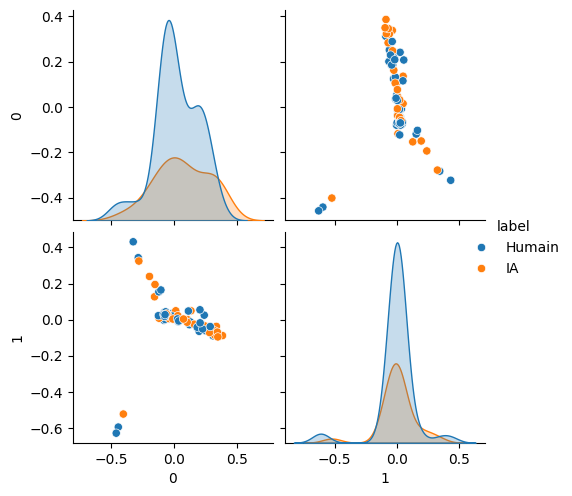

In [32]:
df_pca = pd.DataFrame(pca_projection)
df_pca["label"] = train["label"]

# Tracer le pairplot
pairplot = sns.pairplot(df_pca, hue="label")

# Récupérer la légende créée par seaborn
legend = pairplot._legend

# Renommer les étiquettes dans la légende
legend.texts[0].set_text('Humain')
legend.texts[1].set_text('IA')
plt.show()

Avec cette visualisation en 2D, il semble qu'il est difficile de séparer ce qui est fait par un LLM ou non. Mais lorsqu'on regarde les répartitions, on remarque une certain tendance : Ce qui n'est pas généré par un LLM semble réparti de manière homogène (tandis que le reste semble fortement concentré). Est-ce que cela conforterait l'hypothèse selon laquelle l'IA utilise des expressions bien plus complexes que l'homme ?

Cette fois-ci, avec le t-SNE, nous obtenons la représentation suivante :

In [33]:
df_pca

,0,1,label
0,-0.014345,0.006823,NaN
1,0.003156,-0.008892,NaN
2,0.002148,0.009584,NaN
3,0.199681,-0.032283,NaN
4,-0.075695,0.011466,NaN
...,...,...,...
3995,-0.307391,0.422164,NaN
3996,0.040080,0.017109,NaN
3997,0.190617,-0.046613,NaN
3998,-0.258988,0.343373,NaN


Cette fois-ci, on peut largement mieux différencier ce qui est généré (vers le centre) ou non par un LLM (en périphérie) !

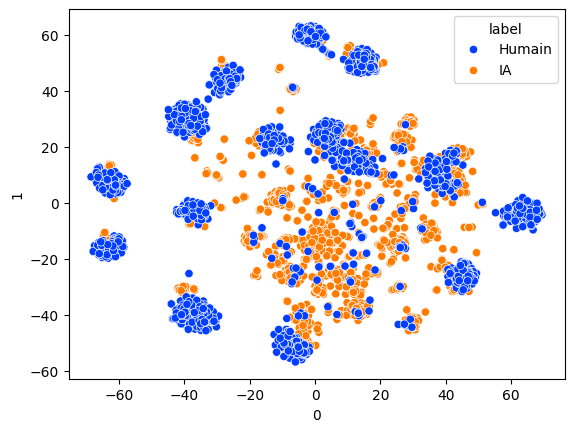

In [34]:
df_tsne = pd.DataFrame({"0": tsne_projection[:, 0], "1": tsne_projection[:, 1], "label": train['label']})
scatterplot = sns.scatterplot(data=df_tsne, x="0", y="1", hue="label", palette="bright")
legend = scatterplot.get_legend()
legend.texts[0].set_text('Humain')
legend.texts[1].set_text('IA')

plt.show()

Le graphe de nuages de points montre bien la difference entre l'humain et l'IA, il s'appuie aussi des résultats par rapport à l'ecart type et variance des indices de lisibilités. 

Les points sont plus concentrés pour l'IA ce qui est adéquation avec le faible ecart-type qu'on a constaté pour les indices. On constate alors une homogénéité stylistique de l'IA. 

Les clusters qu'on voit montrent les differences stylistiques de l'humain. Ces clusters sont dues à la grande différence de profils de l'humain dans ce jeu de données avec les folds.

Cette analyse montre alors les caractéristiques stylistiques des textes générés par l'IA, mais aussi la complexité et la variété des écrits humains. On a aussi des points IA et Humains qui se concordent, on n'est pas sûr à 100% de pouvoir distinguer mais il s'agit d'un début. Pour approfondir cette problématique, il faudrait passer par des méthodes d'apprentissage.
A partir de ces analyses de données, on peut avoir alors distinguer briéfement l'humain et de l'IA mais il faut prendre en compte que la signature n'est pas la même pour chaque IA. Que se passerait-il si une IA va essayer d'imiter le style humain et l'irrégularité de l'humain ?


